In [1]:
from collections import defaultdict, deque
from random import random

import gymnasium as gym
import numpy as np
import random
import imageio
import os
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

In [2]:
class Agent:
    def __init__(
            self,
            start_epsilon=1,
            epsilon_decay=0.9,
            epsilon_cut=0.1,
            alpha=0.01,
            gamma=1,
            number_of_actions=6
                 ):
        self.epsilon = start_epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_cut = epsilon_cut
        self.alpha = alpha
        self.gamma = gamma
        self.na = number_of_actions
        self.model = {}
        self.Q = defaultdict(lambda: np.zeros(self.na))
        
    def select_action(self, state):
        r = random.random()
        if r > self.epsilon:
            return np.argmax(self.Q[state])
        else:
            return random.randint(0, self.na-1)
        
    def step(self, state, action, reward, next_state, done):
        if not done:
            self.Q[state][action] += self.alpha * (
                reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action]
            )
        else:
            self.Q[state][action] += self.alpha * (reward - self.Q[state][action])
            self.epsilon *= self.epsilon_decay
            if self.epsilon_cut is not None:
                self.epsilon = max(self.epsilon, self.epsilon_cut)

In [3]:
# Dyna-Q parameters
n_planning_steps = 5
epsilon_cut = 0
epsilon_decay = 0.8888782926665223
start_epsilon = 0.9957089031634627
gamma = 0.7749915552696941
alpha = 0.2512238484351891

num_episodes = 10000
window = 100

env = gym.make('Taxi-v3')
number_of_actions = env.action_space.n
agent = Agent(
    start_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_cut=epsilon_cut,
    alpha=alpha,
    gamma=gamma,
    number_of_actions=number_of_actions,
)

In [4]:
avg_rewards = deque(maxlen=num_episodes)
best_avg_reward = -np.inf
reward_threshold = 9.7

sampled_rewards = deque(maxlen=window)

for episode in range(1, num_episodes+1):
    state, info = env.reset()
    sampled_reward = 0
    
    while True:
        # agent select an action
        action = agent.select_action(state)
        # agent permorms the selected action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # agent performs internal updates based on sampled experience
        agent.step(state, action, reward, next_state, done)
        # update the sampled reward
        sampled_reward += reward
        
        
        # Model learning
        agent.model[(state, action)] = (next_state, reward)
        # Planning with simulated experiences
        for _ in range(n_planning_steps):
            simulated_state, simulated_action = list(agent.model.keys())[np.random.choice(len(agent.model))]
            simulated_next_state, simulated_reward = agent.model[(simulated_state, simulated_action)]
            agent.step(simulated_state, simulated_action, simulated_reward, simulated_next_state, done)

        
        # update the state
        state = next_state
        
        if done:
            # save final sampled reward
            sampled_rewards.append(sampled_reward)
            break
            
    # every 100 episodes compile average reward
    if episode >= 100:
        avg_reward = np.mean(sampled_rewards)
        avg_rewards.append(avg_reward)
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            
    # monitor
    print(
        "\rEpisode {}/{} || Best average reward {}".format(
            episode, num_episodes, best_avg_reward
        ), end=""
    )
    
    # check if task is solved 
    if best_avg_reward >= reward_threshold:
        print(
            '\nEnvironment solved in {} episodes.'.format(episode),
            end=""
        )
        break

Episode 10000/10000 || Best average reward 4.161

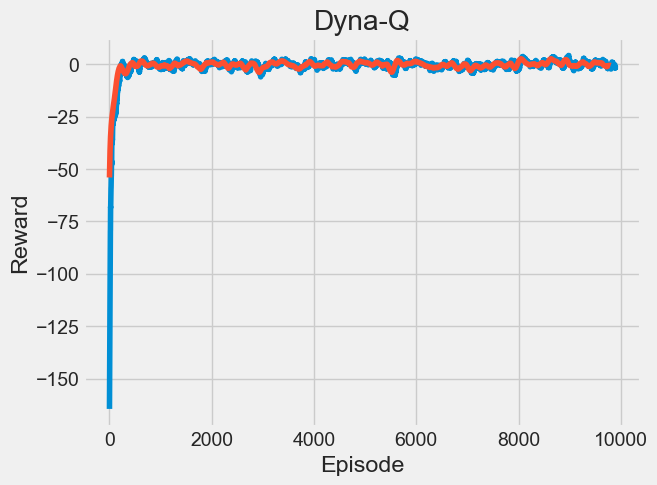

In [5]:
# Вычисление скользящего среднего
window_size = 100
moving_avg = np.convolve(avg_rewards, np.ones(window_size)/window_size, mode='valid')

plt.plot(avg_rewards)
plt.plot(moving_avg)
plt.title('Dyna-Q')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [6]:
def record_video(env, agent, out_directory, fps=30):
    images = []
    done = False
    state, _ = env.reset()
    
    img = env.render()
    images.append(img)
    
    i = 0
    while not done:
        i += 1
        
        action = agent.select_action(state)
        
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        img = env.render()
        images.append(img)
        
        if i > 2000:
            break
    imageio.mimsave('./result/test.gif',
                    [np.array(img) for _, img in enumerate(images)],
                    fps=fps)

In [7]:
os.makedirs('./result/', exist_ok=True)
env_name = 'Taxi-v3'

env = gym.make(env_name, render_mode='rgb_array')
record_video(env, agent, out_directory=None)